<a href="https://colab.research.google.com/github/zolfaShefreie/MCI-Chatbot/blob/tts/english_tacron_nemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#insallation

In [1]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies# .
"""
BRANCH = 'main'
# If you're using Colab and not running locally, uncomment and run this cell.
!apt-get install sox libsndfile1 ffmpeg
!pip install wget text-unidecode
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/nemo_text_processing/install_pynini.sh
!bash install_pynini.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 20 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://

#import

In [3]:
import pandas as pd

import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline
import librosa

from nemo.collections.tts.models.tacotron2 import Tacotron2Model
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder

[NeMo W 2022-12-14 10:13:55 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-12-14 10:13:55 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-14 10:13:55 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


#Working with Tacotron2 model

In [ ]:
# Let's see what pretrained models are available
print(Tacotron2Model.list_available_models())

[PretrainedModelInfo(
	pretrained_model_name=tts_en_tacotron2,
	description=This model is trained on LJSpeech sampled at 22050Hz, and can be used to generate female English voices with an American accent.,
	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.0.0/files/tts_en_tacotron2.nemo,
	class_=<class 'nemo.collections.tts.models.tacotron2.Tacotron2Model'>
)]


In [ ]:
# We can load the pre-trained model as follows
model = Tacotron2Model.from_pretrained("tts_en_tacotron2")

[NeMo I 2022-12-14 07:28:18 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.0.0/files/tts_en_tacotron2.nemo to /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo
[NeMo I 2022-12-14 07:28:22 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-14 07:28:24 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      trim: false
      int_values: false
      load_audio: true
      normalize: true
      sample_rate: 22050
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 48
      num_workers: 4
    
[NeMo W 2022-12-14 07:28:24 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_

[NeMo I 2022-12-14 07:28:25 features:267] PADDING: 16
[NeMo I 2022-12-14 07:28:26 save_restore_connector:243] Model Tacotron2Model was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo.


In [ ]:
vocoder = Vocoder.from_pretrained("tts_hifigan")

[NeMo I 2022-12-14 07:36:42 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-12-14 07:36:50 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-14 07:36:56 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-12-14 07:36:56 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-12-14 07:36:56 features:267] PADDING: 0


[NeMo W 2022-12-14 07:36:56 features:244] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-12-14 07:36:56 features:267] PADDING: 0
[NeMo I 2022-12-14 07:36:58 save_restore_connector:243] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


[NeMo W 2022-12-14 07:28:26 tacotron2:145] parse() is meant to be called in eval mode.


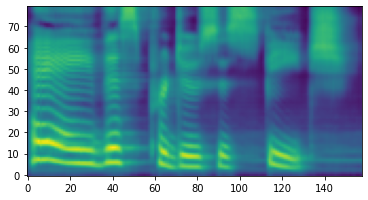

In [ ]:
# Tacotron2 is a SpectrogramGenerator
assert isinstance(model, SpectrogramGenerator)

# SpectrogramGenerators in NeMo have two helper functions:
#   1. parse(self, text: str, normalize=True) which takes an English string and produces a token tensor
#   2. generate_spectrogram(self, *, tokens) which takes the token tensor and generates a spectrogram
# Let's try it out
tokens = model.parse(text = "Hey, this produces speech!")
spectrogram = model.generate_spectrogram(tokens = tokens)

# Now we can visualize the generated spectrogram
# If we want to generate speech, we have to use a vocoder in conjunction to a spectrogram generator.
# Refer to the TTS Inference notebook on how to convert spectrograms to speech.

imshow(spectrogram.cpu().detach().numpy()[0,...], origin="lower")
plt.show()

In [ ]:
audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
audio = audio.cpu().detach().numpy()[0]
print(f'"Hey, this produces speech!"\n')
ipd.Audio(audio, rate=22050)

"Hey, this produces speech!"



#Trainning

In [4]:
# NeMo's training scripts are stored inside the examples/ folder. Let's grab the tacotron2.py file
# as well as the tacotron2.yaml file
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/tacotron2.py
!(mkdir -p conf \
  && cd conf \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/tacotron2.yaml \
  && cd ..)

# We will also need a few extra files for handling text.
!(mkdir -p scripts/tts_dataset_files \
  && cd scripts/tts_dataset_files \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.10 \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-052722 \
  && cd ..)
        
!(mkdir -p nemo_text_processing/text_normalization/en/data/whitelist/ \
  && cd nemo_text_processing/text_normalization/en/data/whitelist/ \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/nemo_text_processing/text_normalization/en/data/whitelist/lj_speech.tsv \
  && cd ..)
  

--2022-12-14 10:14:05--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/tacotron2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1874 (1.8K) [text/plain]
Saving to: ‘tacotron2.py’

tacotron2.py        100%[===================>]   1.83K  --.-KB/s    in 0s      

2022-12-14 10:14:05 (21.0 MB/s) - ‘tacotron2.py’ saved [1874/1874]

--2022-12-14 10:14:05--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/conf/tacotron2.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5444 (5.3K) [text/plain]
Sav

#Dataset
[LJSpeech dataset](https://keithito.com/LJ-Speech-Dataset/) is used here. for more datasets, you can visit [here](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/datasets.html).

download scripts for dataset

In [8]:
!(mkdir -p scripts/dataset_processing/tts \
&& cd scripts/dataset_processing/tts \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/stable/scripts/dataset_processing/tts/extract_sup_data.py\
&& cd ..)

!(mkdir -p scripts/dataset_processing/tts/ljspeech/ \
&& cd scripts/dataset_processing/tts/ljspeech/ \
&& wget https://raw.githubusercontent.com/NVIDIA/NeMo/stable/scripts/dataset_processing/tts/ljspeech/get_data.py\
&& cd ..)

--2022-12-14 10:26:10--  https://raw.githubusercontent.com/NVIDIA/NeMo/stable/scripts/dataset_processing/tts/extract_sup_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2645 (2.6K) [text/plain]
Saving to: ‘extract_sup_data.py’

extract_sup_data.py 100%[===================>]   2.58K  --.-KB/s    in 0s      

2022-12-14 10:26:10 (24.8 MB/s) - ‘extract_sup_data.py’ saved [2645/2645]

--2022-12-14 10:26:11--  https://raw.githubusercontent.com/NVIDIA/NeMo/stable/scripts/dataset_processing/tts/ljspeech/get_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, aw

In [11]:
DATASET_PATH = "./dataset"
MANIFEST_PATH = "/content/dataset/LJSpeech-1.1/train_manifest.json"

!mkdir -p $DATASET_PATH

In [12]:
!python scripts/dataset_processing/tts/ljspeech/get_data.py \
    --data-root $DATASET_PATH \
    --whitelist-path nemo_text_processing/text_normalization/en/data/whitelist/lj_speech.tsv

Streaming output truncated to the last 5000 lines.
3091it [03:33, 14.87it/s]
3093it [03:33, 14.93it/s]
3095it [03:33, 15.25it/s]
3097it [03:33, 15.04it/s]
3099it [03:33, 16.01it/s]
3101it [03:33, 16.14it/s]
3103it [03:34, 16.32it/s]
3105it [03:34, 16.02it/s]
3107it [03:34, 15.52it/s]
3109it [03:34, 15.08it/s]
3111it [03:34, 16.07it/s]
3113it [03:34, 15.05it/s]
3115it [03:34, 15.43it/s]
3117it [03:35, 14.87it/s]
3119it [03:35, 15.21it/s]
3121it [03:35, 15.23it/s]
3123it [03:35, 14.36it/s]
3125it [03:35, 14.31it/s]
3127it [03:35, 14.96it/s]
3129it [03:35, 15.81it/s]
3131it [03:35, 16.56it/s]
3133it [03:36, 16.12it/s]
3135it [03:36, 15.64it/s]
3137it [03:36, 15.73it/s]
3139it [03:36, 15.33it/s]
3141it [03:36, 15.34it/s]
3143it [03:36, 14.97it/s]
3145it [03:36, 15.36it/s]
3147it [03:37, 14.83it/s]
3149it [03:37, 14.36it/s]
3151it [03:37, 13.75it/s]
3153it [03:37, 13.07it/s]
3155it [03:37, 13.92it/s]
3157it [03:37, 14.27it/s]
3159it [03:37, 14.96it/s]
3161it [03:37, 14.84it/s]
3163it [03:38

In [13]:
# !python scripts/dataset_processing/tts/extract_sup_data.py \
#     --config-path ljspeech/ds_conf \
#     --config-name ds_for_fastpitch_align.yaml \
#     manifest_filepath=/content/dataset/LJSpeech-1.1/train_manifest.json \
#     sup_data_path=/content/dataset/LJSpeech-1.1

[NeMo W 2022-12-14 11:02:31 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
Primary config directory not found.
Check that the config directory '/content/scripts/dataset_processing/tts/ljspeech/ds_conf' exists and readable

Set the environment variable HYDRA_FULL_ERROR=1 for a complete stack trace.


#Training

In [ ]:
!(python tacotron2.py \
  model.sample_rate=16000 \
  train_dataset=/content/dataset/LJSpeech-1.1/train_manifest.json \
  validation_datasets=/content/dataset/LJSpeech-1.1/val_manifest.json \
  trainer.max_epochs=2 \
  trainer.accelerator=cpu \
  trainer.check_val_every_n_epoch=1 \
 +trainer.gpus=1)

[NeMo W 2022-12-14 11:19:04 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-12-14 11:19:05 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-14 11:19:05 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-14 11:19:06 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/next/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo W 2022-12-14 11:19:06 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/pytorch_lightnin